# "Instructed OGGM": running IGM within the OGGM workflow
This tutorial gives you the tools to run IGM within OGGM and also compare it with OGGM runs

In [1]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL
from oggm.core import massbalance
from oggm.shop import gcm_climate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import igm

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

## Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

## Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed_', reset=True)

## Pick a glacier
rgi_ids = ['RGI60-11.01450']  # This is Aletsch
# rgi_ids = ['RGI60-11.00897']  # This is Hintereisferner
# rgi_ids = ['RGI60-11.03638']  # This is Argentiere
# base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/exps/igm_v2' # not used currently, data is taken from oggm.DEFAULT_BASE_URL

gdir = workflow.init_glacier_directories(rgi_ids, 
                                         prepro_base_url=DEFAULT_BASE_URL, 
                                         from_prepro_level=4, 
                                         # prepro_border=40,
                                            )[0]


2024-08-24 20:52:13: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-08-24 20:52:13: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-08-24 20:52:13: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-08-24 20:52:20: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-08-24 20:52:20: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


## Add consensus and cook thickness product to the gdir

In [2]:
# add consensus now as well, as we use a different prepro
from oggm.shop import bedtopo
workflow.execute_entity_task(bedtopo.add_consensus_thickness, gdir);

2024-08-24 20:52:21: oggm.workflow: Execute entity tasks [add_consensus_thickness] on 1 glaciers


In [3]:
from oggm.shop import cook23
cook23.cook23_to_gdir(gdir)

### Activate the 3 lines of code in the following code block to match the starting volume with the consensus volume (Farinotti et al. 2019) 
#### Note: the consensus volume is used as a reference volume for OGGM's dynamic spinup during the bed inversion as a reference volume, but in the further workflow only the RGI-area is matched and not the consensus volume. 

In [4]:
# match of consensus
# ### Recompute the volume to match Farinotti et al. 2019 (for consistency with IGM later) 
# from oggm.global_tasks import calibrate_inversion_from_consensus
# calibrate_inversion_from_consensus([gdir])
# get ready for modelling
# tasks.init_present_time_glacier(gdir)

### Running OGGM Flowline with a GCM Climate

In [5]:
# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
member = 'mri-esm2-0_r1i1p1f1' 

for ssp in ['ssp126', 'ssp370','ssp585']:
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdir, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                 # recognize the climate file for later
                                 output_filesuffix=f'_ISIMIP3b_{member}_{ssp}',
                                 );

2024-08-24 20:52:21: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-08-24 20:52:22: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-08-24 20:52:22: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers


In [6]:
for ssp in ['ssp126', 'ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    workflow.execute_entity_task(tasks.run_from_climate_data, gdir,
                                 climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                 climate_input_filesuffix=rid,  # use the chosen scenario
                                 init_model_filesuffix='_spinup_historical',  # this is important! Start from 2020 glacier
                                 output_filesuffix=rid, 
                                 store_fl_diagnostics = True # recognize the run for later
                                );

2024-08-24 20:52:22: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-08-24 20:52:23: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-08-24 20:52:23: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


### create the corresponding mass balance model(MB model) of the run above, so that the iOGGM run can be forced with same MB model
#### (using this MB model with the instructed-oggm doesn't work yet)

In [7]:
mb_gcm = massbalance.MultipleFlowlineMassBalance(gdir, 
                                                   filename='gcm_data',
                                                   bias=0,
                                                   input_filesuffix=f'_ISIMIP3b_{member}_ssp370')

### Running OGGM Flowline with a Random Climate 
#### this run is forced with climate data from 1999-2019 randomly sampled

In [8]:
# Do a random run with a bit of warming
tasks.run_random_climate(gdir, nyears=100, 
                         y0=2009, halfsize=10, # Climate of 1999-2019
                         seed=1,  # Change for another randomness 
                         temperature_bias=0,  # casual warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         output_filesuffix='_rdn_1',  # name the run
                         init_model_filesuffix='_spinup_historical',
                        );

### create the corresponding random mass balance model(MB model) of the run above, so that the iOGGM run can be forced with same random MB model

In [9]:
mb_rand = massbalance.RandomMassBalance(gdir,
                                   y0=2009, halfsize=10, # Climate of 1999-2019
                                   seed=1,  # Change for another randomness
                                   )

In [10]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as gd:
    gd = gd.load()

# set values outside the glacier to np.nan
# using the glacier mask, as otherwise there is more ice from surrounding glaciers in the domain, 
# which shouldn't accumulate more ice, still adds to the total volume/area of the domain.. either mask it out beforehand or before doing plots.
# experiment with it: does the mass outside of the mask only decrease? => ?
gd['cook23_thk_masked'] = xr.where(gd.glacier_mask, gd.cook23_thk, np.nan)



In [11]:
bed_con = gd.topo - gd.consensus_ice_thickness.fillna(0)
bed_cook_masked = gd.topo - gd.cook23_thk_masked.fillna(0)
bed_cook = gd.topo - gd.cook23_thk

### Running the iOGGM from the consensus ice thickness (Farinotti et al. 2019)
#### once with random and once with the same GCM climate as above

In [12]:
############################### OGGM-IGM - CONSENSUS - RANDOM CLIMATE
from igm.instructed_oggm import IGM_Model2D

sdmodel_igm_con_rnd = IGM_Model2D(bed_con.values, init_ice_thick=gd.consensus_ice_thickness.fillna(0).values, 
                     dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed_con.x, y=bed_con.y, mb_model=mb_rand, 
                        y0=0., mb_filter=gd.glacier_mask.values==1)

dsr_igm_con_rnd = sdmodel_igm_con_rnd.run_until_and_store(100, grid=gdir.grid)

2024-08-24 20:52:23.610110: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-24 20:52:23.610132: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-24 20:52:23.610141: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-24 20:52:23.610170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-24 20:52:23.610182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


/Users/afisc/igm_venv/lib/python3.10/site-packages/tensorflow/python/framework/tensor_util.py:518: RuntimeWarning: overflow encountered in cast
  nparray = np.array(values, dtype=np_dt)
2024-08-24 20:52:25.327482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [13]:
############################### OGGM-IGM - CONSENSUS - GCM CLIMATE
from igm.instructed_oggm import IGM_Model2D

sdmodel_igm_con_gcm = IGM_Model2D(bed_con.values, init_ice_thick=gd.consensus_ice_thickness.fillna(0).values, 
                                    dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed_con.x, y=bed_con.y, mb_model=mb_gcm, 
                                    y0=gdir.rgi_date, mb_filter=gd.glacier_mask.values==1)
dsr_igm_con_gcm = sdmodel_igm_con_gcm.run_until_and_store(2100, grid=gdir.grid)

Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


### Running the iOGGM from the Cook et al. 2023 ice thickness product
#### once with random and once with the same GCM climate as above

In [14]:
############################### OGGM-IGM - COOK_23 - RANDOM CLIMATE
sdmodel_igm_cook_rnd = IGM_Model2D(bed_cook_masked.values, init_ice_thick=gd.cook23_thk_masked.fillna(0).values, 
                     dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed_cook_masked.x, y=bed_cook_masked.y, mb_model=mb_rand, 
                        y0=0., mb_filter=gd.glacier_mask.values==1)

dsr_igm_cook_rnd = sdmodel_igm_cook_rnd.run_until_and_store(100, grid=gdir.grid)

Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


In [15]:
############################### OGGM-IGM - COOK_23 - GCM CLIMATE
sdmodel_igm_cook_gcm = IGM_Model2D(bed_cook_masked.values, init_ice_thick=gd.cook23_thk_masked.fillna(0).values, 
                     dx=gdir.grid.dx, dy=gdir.grid.dy, x=bed_cook_masked.x, y=bed_cook_masked.y, mb_model=mb_gcm, 
                        y0=gdir.rgi_date, mb_filter=gd.glacier_mask.values==1)

dsr_igm_cook_gcm = sdmodel_igm_cook_gcm.run_until_and_store(2100, grid=gdir.grid)

Found pretrained emulator in the igm package: pinnbp_10_4_cnn_16_32_2_1


## load the data from disk for plotting

In [16]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics', filesuffix='_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp370'), group=f'fl_0') as ds_gcm:
    ds_gcm = ds_gcm.load()

In [17]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics', filesuffix='_rdn_1'), group=f'fl_0') as ds_rnd:
    ds_rnd = ds_rnd.load()

In [18]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics', filesuffix='_spinup_historical'), group=f'fl_0') as spinup:
    spinup = spinup.load()


#### adapt starting date for the random runs

In [19]:
for df in [ds_rnd, dsr_igm_con_rnd, dsr_igm_cook_rnd]:
    df.coords['time'] = df.coords['time'] + gdir.rgi_date
ds_rnd.coords['time'] =  ds_rnd.coords['time'] + (int(spinup.coords['time'][-1])-gdir.rgi_date) 

### Volume plot - both scenarios

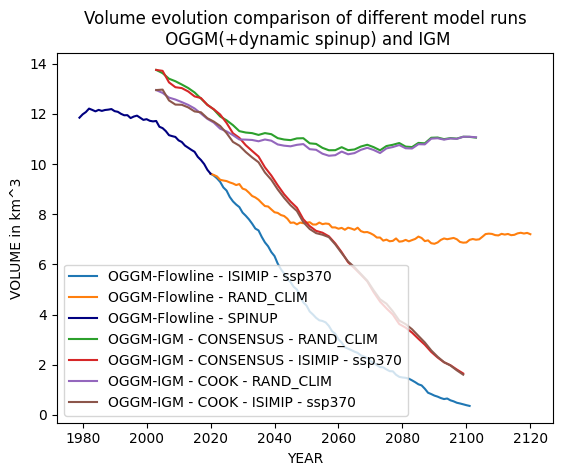

In [22]:
# comparison plots
# OGGM Flowline
(ds_gcm.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - ISIMIP - ssp370');
(ds_rnd.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - RAND_CLIM');
(spinup.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - SPINUP', color='navy');

# IGM (from consensus volume)
(dsr_igm_con_rnd.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - CONSENSUS - RAND_CLIM');
(dsr_igm_con_gcm.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - CONSENSUS - ISIMIP - ssp370');

# IGM (from cook23 volume)
(dsr_igm_cook_rnd.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - COOK - RAND_CLIM');
(dsr_igm_cook_gcm.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - COOK - ISIMIP - ssp370');

plt.ylabel('VOLUME in km^3')
plt.xlabel('YEAR')
plt.title('Volume evolution comparison of different model runs\n OGGM(+dynamic spinup) and IGM');
plt.legend();

### volume plot cropped - GCM only

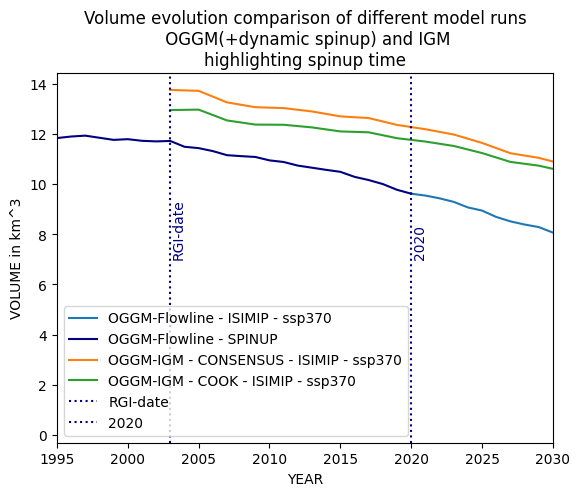

In [23]:
# comparison plots
# OGGM Flowline
(ds_gcm.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - ISIMIP - ssp370');
# (ds_rnd.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - RAND_CLIM');
(spinup.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - SPINUP', color='navy');

# IGM (from consensus volume)
# (dsr_igm_con_rnd.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - CONSENSUS - RAND_CLIM');
(dsr_igm_con_gcm.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - CONSENSUS - ISIMIP - ssp370');

# IGM (from cook23 volume)
# (dsr_igm_cook_rnd.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - COOK - RAND_CLIM');
(dsr_igm_cook_gcm.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - COOK - ISIMIP - ssp370');

# rgi date
plt.axvline(x=2003, color='navy', linestyle=':', label='RGI-date')
plt.text(2003.1, 7, 'RGI-date', rotation=90, verticalalignment='bottom', color='navy')

# 2020
plt.axvline(x=2020, color='navy', linestyle=':', label='2020')
plt.text(2020.1, 7, '2020', rotation=90, verticalalignment='bottom', color='navy')

plt.ylabel('VOLUME in km^3')
plt.xlabel('YEAR')

plt.xlim(1995, 2030)
# plt.ylim()
plt.title('Volume evolution comparison of different model runs\n OGGM(+dynamic spinup) and IGM\n'
            'highlighting spinup time');
# plt.xlim(2000, 2030)
# plt.ylim(8, 15)
plt.legend();

### gcm climate only - volume plot

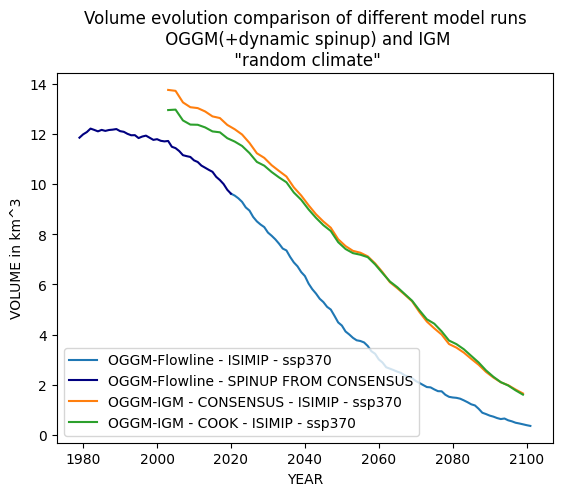

In [24]:
(ds_gcm.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - ISIMIP - ssp370');
(spinup.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - SPINUP FROM CONSENSUS', color='navy');
(dsr_igm_con_gcm.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - CONSENSUS - ISIMIP - ssp370');
(dsr_igm_cook_gcm.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - COOK - ISIMIP - ssp370');
plt.ylabel('VOLUME in km^3')
plt.xlabel('YEAR')
plt.title('Volume evolution comparison of different model runs\n OGGM(+dynamic spinup) and IGM\n \" climate\"');
plt.legend();

### random climate only - volume plot

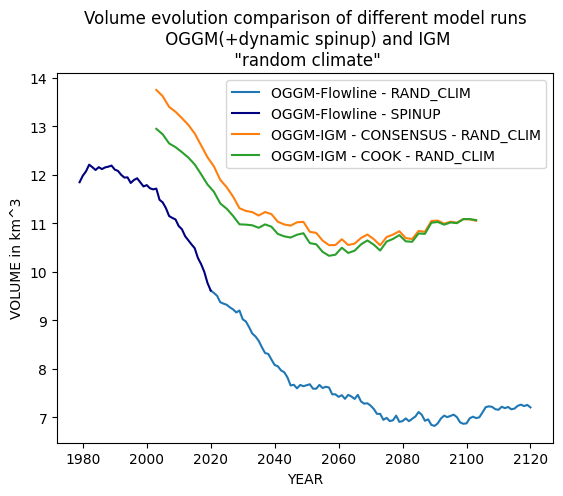

In [25]:
(ds_rnd.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - RAND_CLIM');
(spinup.volume_m3.sum(dim=['dis_along_flowline'])*1e-9).plot(label='OGGM-Flowline - SPINUP', color='navy');
(dsr_igm_con_rnd.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - CONSENSUS - RAND_CLIM');
(dsr_igm_cook_rnd.ice_thickness.sum(dim=['x', 'y'])*gdir.grid.dx**2*1e-9).plot(label='OGGM-IGM - COOK - RAND_CLIM');
plt.ylabel('VOLUME in km^3')
plt.xlabel('YEAR')
plt.title('Volume evolution comparison of different model runs\n OGGM(+dynamic spinup) and IGM\n \"random climate\"');
plt.legend();

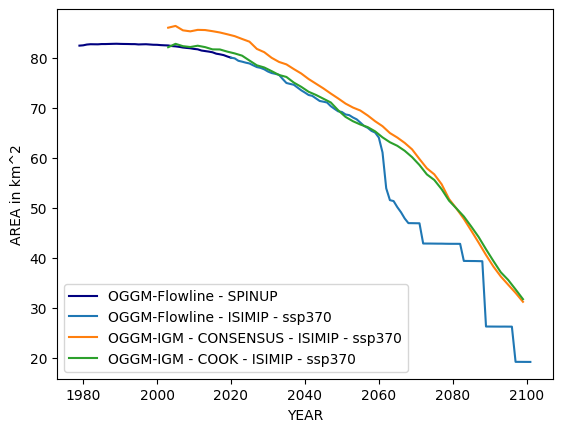

In [29]:
(spinup.area_m2.sum(dim=['dis_along_flowline'])*1e-6).plot(label='OGGM-Flowline - SPINUP', color='navy');
(ds_gcm.area_m2.sum(dim=['dis_along_flowline'])*1e-6).plot(label='OGGM-Flowline - ISIMIP - ssp370');
# (ds_rnd.area_m2.sum(dim=['dis_along_flowline'])*1e-6).plot(label='OGGM-Flowline - RAND_CLIM');


# ((dsr_igm_con_rnd.ice_thickness > 1).sum(dim=['x', 'y']) *gdir.grid.dx**2*1e-6).plot(label='OGGM-IGM - CONSENSUS- RAND_CLIM');
((dsr_igm_con_gcm.ice_thickness > 1).sum(dim=['x', 'y']) *gdir.grid.dx**2*1e-6).plot(label='OGGM-IGM - CONSENSUS - ISIMIP - ssp370');
# ((dsr_igm_cook_rnd.ice_thickness > 1).sum(dim=['x', 'y']) *gdir.grid.dx**2*1e-6).plot(label='OGGM-IGM - COOK - RAND_CLIM');
((dsr_igm_cook_gcm.ice_thickness > 1).sum(dim=['x', 'y']) *gdir.grid.dx**2*1e-6).plot(label='OGGM-IGM - COOK - ISIMIP - ssp370');
plt.ylabel('AREA in km^2')
plt.xlabel('YEAR')
# plt.xlim(2000, 2030)
# plt.ylim(75, 90)
plt.legend();
